# Import audio file, split according to rate and convert to mono

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython.display import Audio

## Split to keep first seconds

### Fonction

In [2]:
'''
Objective : Split audio tensor to keep only first seconds
Input : AudioIOTensor
Output : tf.Tensor
'''

TARGET_SPLIT_DURATION_SEC = 10

def split_audio(audio):
    # Get split index adequate to audio rate
    split_index = audio.rate.numpy() * TARGET_SPLIT_DURATION_SEC
    # Split if audio length > split_index
    if audio.shape.numpy()[0] > split_index :
        return audio[:split_index]
    return audio[:]

### Tests

In [3]:
# Test avec son long et stereo
file = "../raw_data/subdataset_cs/train/Aegolius-funereus-131493.mp3"
audio1 = tfio.audio.AudioIOTensor(file)
audio1

<AudioIOTensor: shape=[4437504       2], dtype=<dtype: 'float32'>, rate=44100>

In [4]:
split1 = split_audio(audio1)
split1

<tf.Tensor: shape=(441000, 2), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00],
       [9.5395428e-12, 1.0522362e-10],
       [2.2586129e-11, 9.0583104e-11],
       ...,
       [8.8172196e-04, 9.6597435e-04],
       [9.7899744e-04, 1.2803953e-03],
       [1.3221783e-03, 1.7317437e-03]], dtype=float32)>

In [5]:
# Test avec son court et mono
audio2 = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')
audio2

<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>

In [6]:
split2 = split_audio(audio2)
split2

<tf.Tensor: shape=(28979, 1), dtype=int16, numpy=
array([[-184],
       [-181],
       [-156],
       ...,
       [  56],
       [  81],
       [  83]], dtype=int16)>

## Reduce dimension

### Fonction

In [7]:
'''
Objective : Harmonize tensor shape and dtype of audio to shape (x,),dtype=float32
Input : tf.Tensor shape (x,2) stereo or (x,1) mono
Output : tf.Tensor shape(x,)
'''

def harmonize_tensor_shape(audio):
    # Convert to float32 dtype if necessary
    if audio.dtype == tf.int16 :
        audio = tf.cast(audio, tf.float32) / 32768.0
    # Convert stero to mono if adequate :
    if audio.shape[1] == 2 :
        return tf.reduce_mean(audio, 1)
    # Remove last dimension if mono sound
    return tf.squeeze(audio, axis=[-1])

### Tests

In [8]:
# Test avec son long et stereo
split1

<tf.Tensor: shape=(441000, 2), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00],
       [9.5395428e-12, 1.0522362e-10],
       [2.2586129e-11, 9.0583104e-11],
       ...,
       [8.8172196e-04, 9.6597435e-04],
       [9.7899744e-04, 1.2803953e-03],
       [1.3221783e-03, 1.7317437e-03]], dtype=float32)>

In [9]:
reduced_split = harmonize_tensor_shape(split1)
reduced_split

<tf.Tensor: shape=(441000,), dtype=float32, numpy=
array([0.0000000e+00, 5.7381582e-11, 5.6584615e-11, ..., 9.2384813e-04,
       1.1296964e-03, 1.5269610e-03], dtype=float32)>

In [10]:
Audio(reduced_split.numpy(), rate=audio1.rate.numpy())

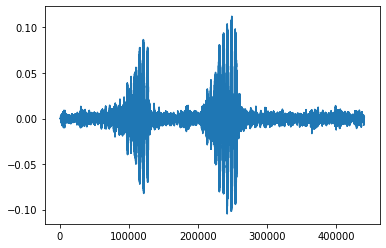

In [11]:
plt.plot(reduced_split.numpy());

In [12]:
# Test avec son court et mono
split2

<tf.Tensor: shape=(28979, 1), dtype=int16, numpy=
array([[-184],
       [-181],
       [-156],
       ...,
       [  56],
       [  81],
       [  83]], dtype=int16)>

In [13]:
reduced_split2 = harmonize_tensor_shape(split2)
reduced_split2

<tf.Tensor: shape=(28979,), dtype=float32, numpy=
array([-0.00561523, -0.00552368, -0.00476074, ...,  0.00170898,
        0.00247192,  0.00253296], dtype=float32)>

In [14]:
reduced_split2

<tf.Tensor: shape=(28979,), dtype=float32, numpy=
array([-0.00561523, -0.00552368, -0.00476074, ...,  0.00170898,
        0.00247192,  0.00253296], dtype=float32)>

In [15]:
Audio(reduced_split2.numpy(), rate=audio2.rate.numpy())

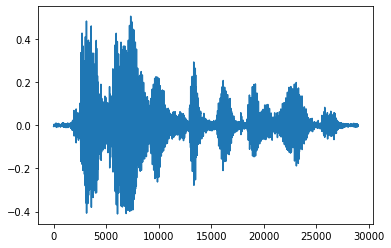

In [16]:
plt.plot(reduced_split2.numpy());

# Spectrogram

In [100]:
'''
Objective : Generate spectrogram
Input : Audio tf.Tensor shape(x,)
Ouput : Spectrogram tf.Tensor shape (x,y)
'''

def generate_spectrogram(audio,nfft=2048,window=512,stride=512):
    spectrogram = tfio.audio.spectrogram(
        audio,
        nfft=nfft,
        window=window,
        stride=stride)
    return tf.transpose(spectrogram,[0,1])

In [96]:
'''
Objective : Generate spectrogram
Input : Audio tf.Tensor shape(x,)
Ouput : Spectrogram tf.Tensor shape (x,y)
'''

def generate_spectrogram(audio,nfft=2048,window=512,stride=512):
    spectrogram = tfio.audio.spectrogram(
        audio,
        nfft=nfft,
        window=window,
        stride=stride)
    return tf.reverse(spectrogram,axis=0)

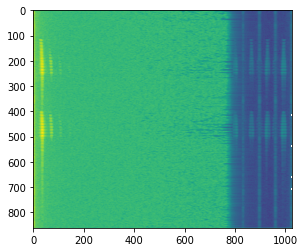

In [101]:
# Convert to spectrogram
spectrogram = generate_spectrogram(reduced_split)
plt.imshow(tf.math.log(spectrogram).numpy());

In [93]:
spectrogram.shape

TensorShape([862, 1025])

In [88]:
spectro.shape

(1025, 862)

In [28]:
reduced_split

<tf.Tensor: shape=(441000,), dtype=float32, numpy=
array([0.0000000e+00, 5.7381582e-11, 5.6584615e-11, ..., 9.2384813e-04,
       1.1296964e-03, 1.5269610e-03], dtype=float32)>

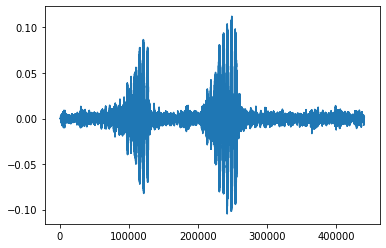

In [29]:
plt.plot(reduced_split.numpy());

In [42]:
reduced_split.numpy()

array([0.0000000e+00, 5.7381582e-11, 5.6584615e-11, ..., 9.2384813e-04,
       1.1296964e-03, 1.5269610e-03], dtype=float32)

(1025, 862)


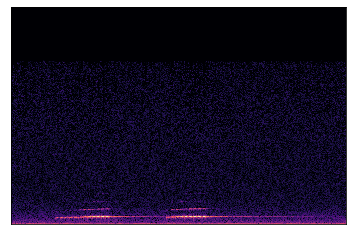

In [98]:
import librosa
import librosa.display
spectro = librosa.stft(reduced_split.numpy(),n_fft=2048,hop_length=512)
print(spectro.shape)
S_db = librosa.amplitude_to_db(np.abs(spectro), ref=np.max)
librosa.display.specshow(S_db);